In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def adjust_epsilon_1(fr_X, epsilon_2, dt=0.001):
    """
    Adjust epsilon_1 such that the firing rate of Y matches the firing rate of X.
    """
    p_X = fr_X * dt  # Probability of X firing in each time bin
    epsilon_1 = (1 - epsilon_2) / (1 - p_X)
    epsilon_1 = np.clip(epsilon_1, 0, 1)
    return epsilon_1

def generate_spike_trains_coupl(length=250, trials=1, fr_X=40, epsilon_2=0.1):
    """
    Generates X and Y spike train matrices using epsilon parameters.
    """
    dt = 0.001  # 1 ms time bins
    p_fire_X = fr_X * dt  # Probability of firing in each time bin
    epsilon_1 = adjust_epsilon_1(fr_X, epsilon_2)
    
    # Generate X matrix
    X = np.random.rand(trials, length) < p_fire_X  # Binary matrix
    
    # Generate Y matrix based on X and epsilon parameters
    Y = np.zeros((trials, length), dtype=int)
    for trial in range(trials):
        for t in range(length):
            if X[trial, t]:
                # If X fired, Y fires with probability (1 - epsilon_2)
                Y[trial, t] = np.random.rand() < (1 - epsilon_2)
            else:
                # If X didn't fire, Y fires with probability (1 - epsilon_1)
                Y[trial, t] = np.random.rand() < (1 - epsilon_1)
    return X.astype(int), Y.astype(int)

In [27]:
def estimate_epsilon_2_ML(X, Y):
    """
    Estimates epsilon_2 using the Maximum Likelihood estimator.
    """
    X1_indices = X == 1  # Indices where X is 1
    if np.sum(X1_indices) == 0:
        return np.nan  # Avoid division by zero
    num_Y0_given_X1 = np.sum(Y[X1_indices] == 0)
    num_X1 = np.sum(X1_indices)
    epsilon_2_ML = num_Y0_given_X1 / num_X1
    return epsilon_2_ML

In [28]:
def estimate_epsilon_2_KT(X, Y):
    """
    Estimates epsilon_2 using the Krichevsky-Trofimov estimator.
    """
    X1_indices = X == 1  # Indices where X is 1
    num_Y0_given_X1 = np.sum(Y[X1_indices] == 0)
    num_X1 = np.sum(X1_indices)
    epsilon_2_KT = (num_Y0_given_X1 + 0.5) / (num_X1 + 1)
    return epsilon_2_KT


In [40]:
# Parameters
fr_X = 40  # Firing rate of X in Hz
length = 1000  # Length of spike trains
trials = 100  # Number of trials for statistics
epsilon_2_values =epsilon_2_values = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]  # Coupling strengths from 0 to 1


In [41]:
# Arrays to store estimated epsilon_2
epsilon_2_ML_estimates = []
epsilon_2_KT_estimates = []
epsilon_2_true = []

for epsilon_2 in epsilon_2_values:
    epsilon_2_estimates_ML_trials = []
    epsilon_2_estimates_KT_trials = []
    
    for _ in range(trials):
        # Generate spike trains
        X, Y = generate_spike_trains_coupl(length=length, trials=1, fr_X=fr_X, epsilon_2=epsilon_2)
        X = X.flatten()
        Y = Y.flatten()
        
        # Estimate epsilon_2 using ML
        epsilon_2_ML = estimate_epsilon_2_ML(X, Y)
        # Estimate epsilon_2 using KT
        epsilon_2_KT = estimate_epsilon_2_KT(X, Y)
        
        # Append estimates
        epsilon_2_estimates_ML_trials.append(epsilon_2_ML)
        epsilon_2_estimates_KT_trials.append(epsilon_2_KT)
    
    # Compute mean estimates over trials
    mean_epsilon_2_ML = np.nanmean(epsilon_2_estimates_ML_trials)
    mean_epsilon_2_KT = np.nanmean(epsilon_2_estimates_KT_trials)
    
    epsilon_2_ML_estimates.append(mean_epsilon_2_ML)
    epsilon_2_KT_estimates.append(mean_epsilon_2_KT)
    epsilon_2_true.append(epsilon_2)


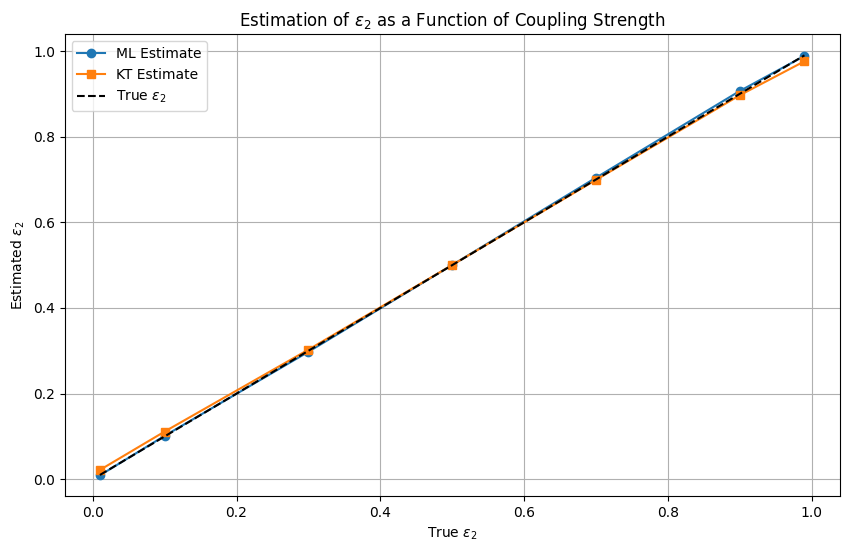

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(epsilon_2_true, epsilon_2_ML_estimates, 'o-', label='ML Estimate')
plt.plot(epsilon_2_true, epsilon_2_KT_estimates, 's-', label='KT Estimate')
plt.plot(epsilon_2_true, epsilon_2_true, 'k--', label='True $\\epsilon_2$')
plt.xlabel('True $\\epsilon_2$')
plt.ylabel('Estimated $\\epsilon_2$')
plt.title('Estimation of $\\epsilon_2$ as a Function of Coupling Strength')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
def trial_length_study(epsilon_2_true, length_values, trials=100, fr_X=40):
    epsilon_2_ML_means = []
    epsilon_2_ML_stds = []
    epsilon_2_KT_means = []
    epsilon_2_KT_stds = []
    lengths_used = []
    
    for length in length_values:
        epsilon_2_estimates_ML_trials = []
        epsilon_2_estimates_KT_trials = []
        
        for _ in range(trials):
            # Generate spike trains
            X, Y = generate_spike_trains_coupl(length=length, trials=1, fr_X=fr_X, epsilon_2=epsilon_2_true)
            X = X.flatten()
            Y = Y.flatten()
            
            # Estimate epsilon_2 using ML
            epsilon_2_ML = estimate_epsilon_2_ML(X, Y)
            # Estimate epsilon_2 using KT
            epsilon_2_KT = estimate_epsilon_2_KT(X, Y)
            
            # Append estimates if they are not NaN
            if not np.isnan(epsilon_2_ML):
                epsilon_2_estimates_ML_trials.append(epsilon_2_ML)
            if not np.isnan(epsilon_2_KT):
                epsilon_2_estimates_KT_trials.append(epsilon_2_KT)
        
        # Compute mean and std estimates over trials
        mean_epsilon_2_ML = np.mean(epsilon_2_estimates_ML_trials)
        std_epsilon_2_ML = np.std(epsilon_2_estimates_ML_trials)
        
        mean_epsilon_2_KT = np.mean(epsilon_2_estimates_KT_trials)
        std_epsilon_2_KT = np.std(epsilon_2_estimates_KT_trials)
        
        epsilon_2_ML_means.append(mean_epsilon_2_ML)
        epsilon_2_ML_stds.append(std_epsilon_2_ML)
        
        epsilon_2_KT_means.append(mean_epsilon_2_KT)
        epsilon_2_KT_stds.append(std_epsilon_2_KT)
        
        lengths_used.append(length)
    
    return (lengths_used, epsilon_2_ML_means, epsilon_2_ML_stds,
            epsilon_2_KT_means, epsilon_2_KT_stds)

In [44]:
# Different true epsilon_2 values to test
epsilon_2_values = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]

# Spike train lengths to test
length_values = [50, 100, 200, 500, 1000, 2000, 5000]

# Number of trials for statistics
trials = 100

# Firing rate of X in Hz
fr_X = 40

In [45]:
# List to hold results for each epsilon_2
results = []

for epsilon_2_true in epsilon_2_values:
    print(f"Running trial length study for true epsilon_2 = {epsilon_2_true}")
    result = trial_length_study(epsilon_2_true, length_values, trials=trials, fr_X=fr_X)
    results.append((epsilon_2_true, result))

Running trial length study for true epsilon_2 = 0.01
Running trial length study for true epsilon_2 = 0.1
Running trial length study for true epsilon_2 = 0.3
Running trial length study for true epsilon_2 = 0.5
Running trial length study for true epsilon_2 = 0.7
Running trial length study for true epsilon_2 = 0.9
Running trial length study for true epsilon_2 = 0.99


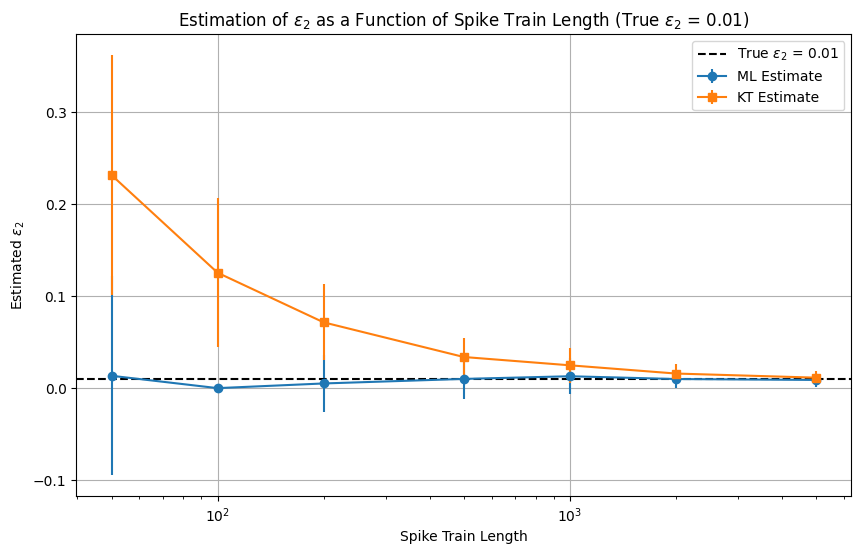

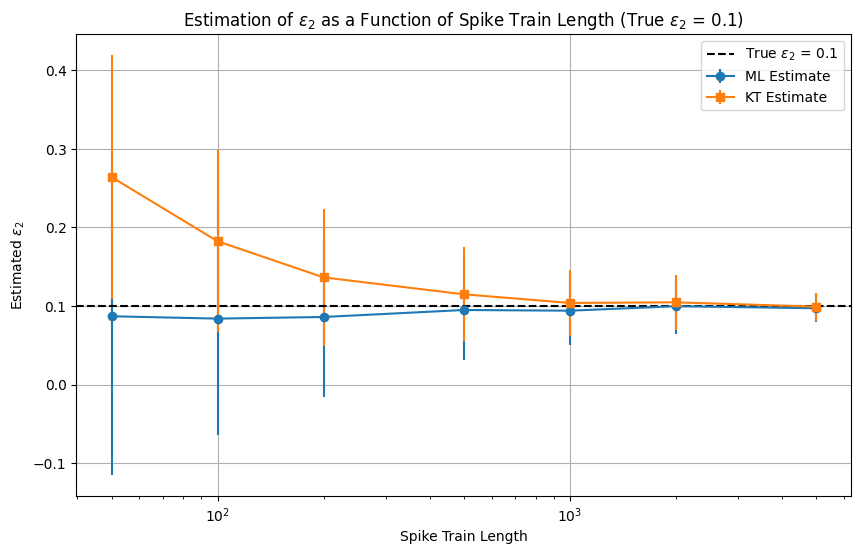

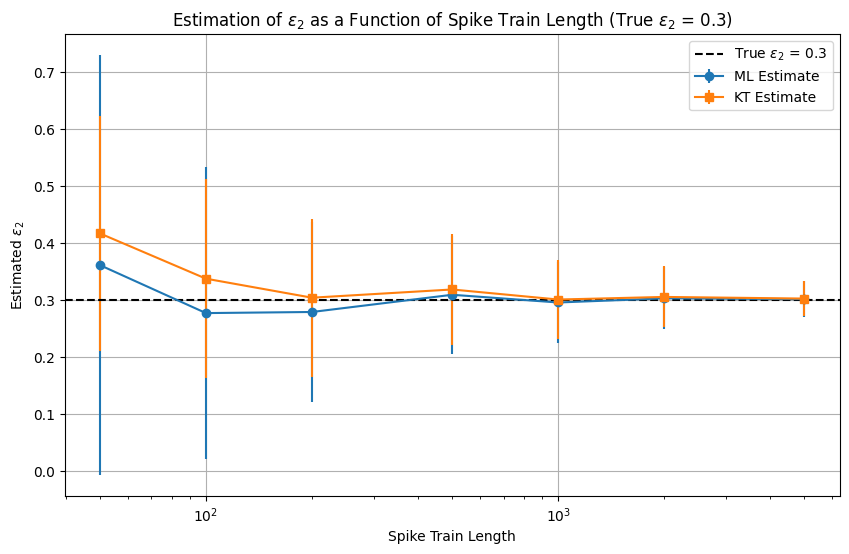

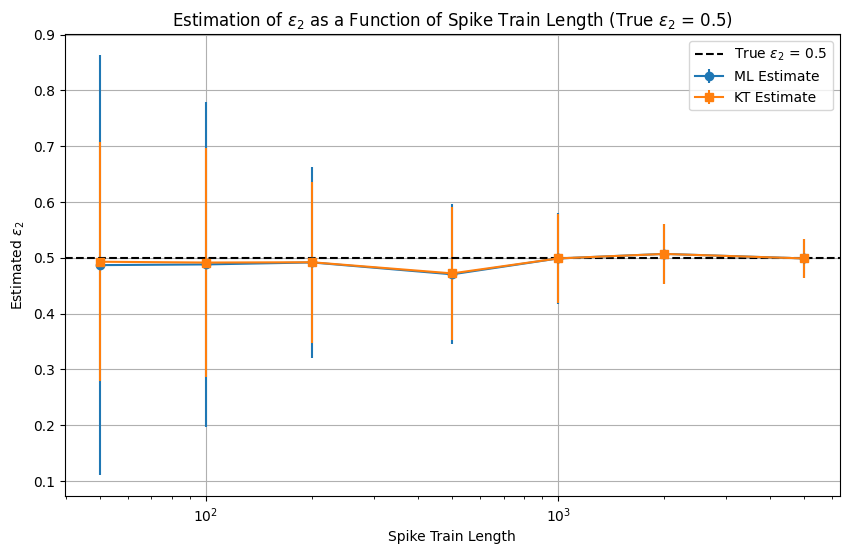

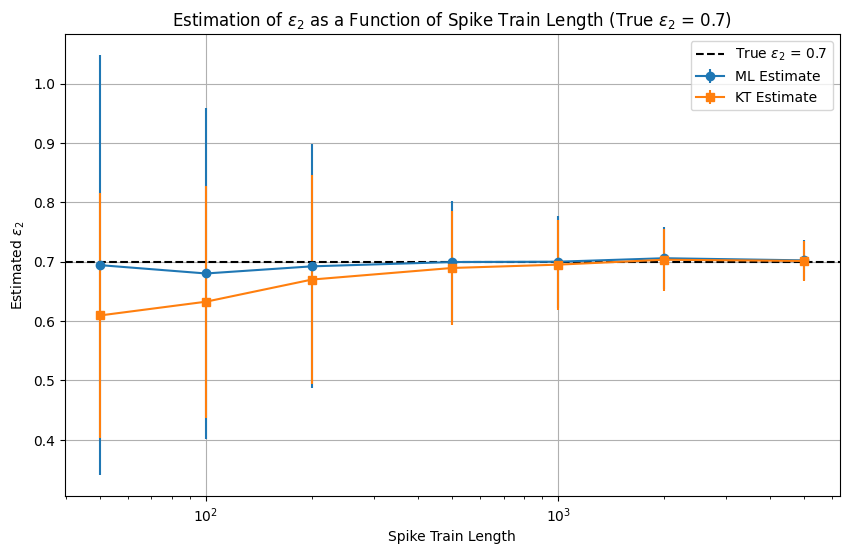

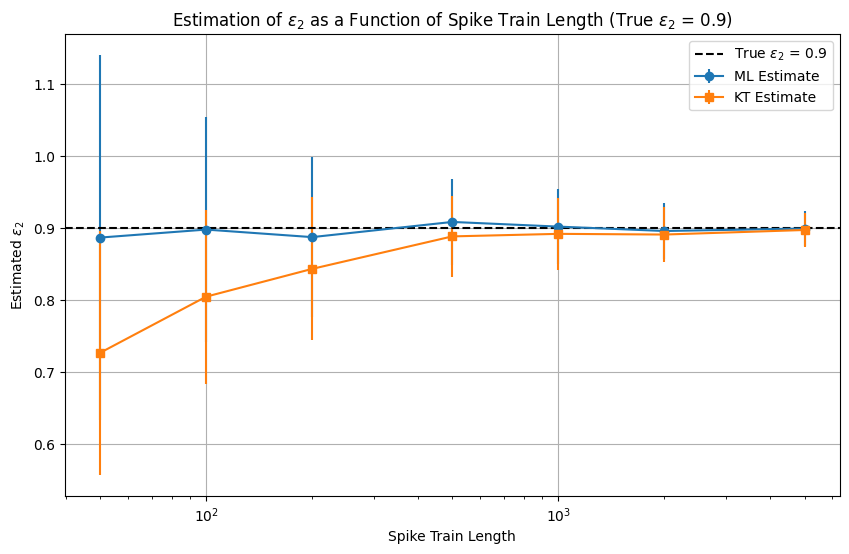

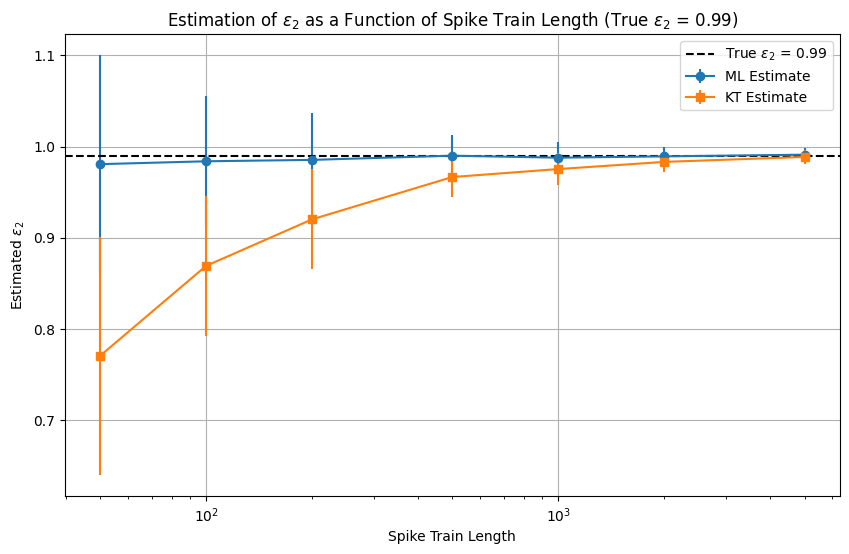

In [46]:
# Plotting the results
for epsilon_2_true, result in results:
    lengths_used, epsilon_2_ML_means, epsilon_2_ML_stds, epsilon_2_KT_means, epsilon_2_KT_stds = result
    
    plt.figure(figsize=(10, 6))
    
    # Plot ML estimates with error bars
    plt.errorbar(lengths_used, epsilon_2_ML_means, yerr=epsilon_2_ML_stds, fmt='o-', label='ML Estimate')
    
    # Plot KT estimates with error bars
    plt.errorbar(lengths_used, epsilon_2_KT_means, yerr=epsilon_2_KT_stds, fmt='s-', label='KT Estimate')
    
    # Plot true epsilon_2 line
    plt.axhline(y=epsilon_2_true, color='k', linestyle='--', label=f'True $\\epsilon_2$ = {epsilon_2_true}')
    
    plt.xscale('log')
    plt.xlabel('Spike Train Length')
    plt.ylabel('Estimated $\\epsilon_2$')
    plt.title(f'Estimation of $\\epsilon_2$ as a Function of Spike Train Length (True $\\epsilon_2$ = {epsilon_2_true})')
    plt.legend()
    plt.grid(True)
    plt.show()

In [47]:
def firing_rate_study(epsilon_2_true, fr_values, length=250, trials=100):
    """
    Performs a firing rate study for a given true epsilon_2 value.
    
    Parameters:
    - epsilon_2_true: The true epsilon_2 value to test.
    - fr_values: A list or array of firing rates to test (in Hz).
    - length: Length of the spike trains (default is 1000 time bins).
    - trials: Number of trials to run for each firing rate (default is 100).
    
    Returns:
    - fr_used: List of firing rates used in the study.
    - epsilon_2_ML_means: Mean ML estimates for each firing rate.
    - epsilon_2_ML_stds: Standard deviation of ML estimates for each firing rate.
    - epsilon_2_KT_means: Mean KT estimates for each firing rate.
    - epsilon_2_KT_stds: Standard deviation of KT estimates for each firing rate.
    """
    epsilon_2_ML_means = []
    epsilon_2_ML_stds = []
    epsilon_2_KT_means = []
    epsilon_2_KT_stds = []
    fr_used = []
    
    for fr_X in fr_values:
        epsilon_2_estimates_ML_trials = []
        epsilon_2_estimates_KT_trials = []
        
        for _ in range(trials):
            # Generate spike trains
            X, Y = generate_spike_trains_coupl(length=length, trials=1, fr_X=fr_X, epsilon_2=epsilon_2_true)
            X = X.flatten()
            Y = Y.flatten()
            
            # Estimate epsilon_2 using ML
            epsilon_2_ML = estimate_epsilon_2_ML(X, Y)
            # Estimate epsilon_2 using KT
            epsilon_2_KT = estimate_epsilon_2_KT(X, Y)
            
            # Append estimates if they are not NaN
            if not np.isnan(epsilon_2_ML):
                epsilon_2_estimates_ML_trials.append(epsilon_2_ML)
            if not np.isnan(epsilon_2_KT):
                epsilon_2_estimates_KT_trials.append(epsilon_2_KT)
        
        # Compute mean and std estimates over trials
        mean_epsilon_2_ML = np.mean(epsilon_2_estimates_ML_trials)
        std_epsilon_2_ML = np.std(epsilon_2_estimates_ML_trials)
        
        mean_epsilon_2_KT = np.mean(epsilon_2_estimates_KT_trials)
        std_epsilon_2_KT = np.std(epsilon_2_estimates_KT_trials)
        
        epsilon_2_ML_means.append(mean_epsilon_2_ML)
        epsilon_2_ML_stds.append(std_epsilon_2_ML)
        
        epsilon_2_KT_means.append(mean_epsilon_2_KT)
        epsilon_2_KT_stds.append(std_epsilon_2_KT)
        
        fr_used.append(fr_X)
    
    return (fr_used, epsilon_2_ML_means, epsilon_2_ML_stds,
            epsilon_2_KT_means, epsilon_2_KT_stds)


In [48]:
# Fixed true epsilon_2 value
epsilon_2_true = 0.5  # You can change this value to test others

# Firing rates to test (from 10 Hz to 100 Hz)
fr_values = np.arange(10, 110, 10)  # Firing rates from 10 Hz to 100 Hz in steps of 10 Hz

# Length of spike trains
length = 1000  # You can adjust this value as needed

# Number of trials for statistics
trials = 100  # Adjust based on desired statistical confidence


Running firing rate study for true epsilon_2 = 0.01


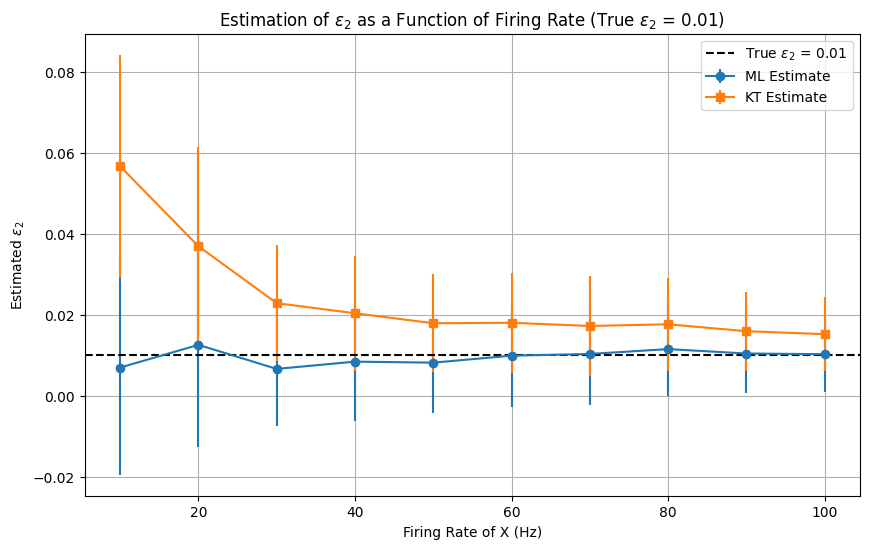

Running firing rate study for true epsilon_2 = 0.1


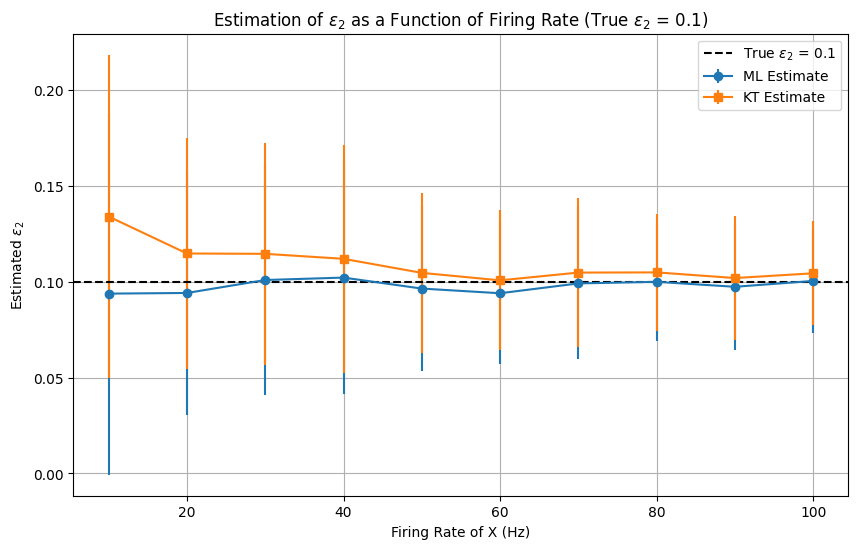

Running firing rate study for true epsilon_2 = 0.3


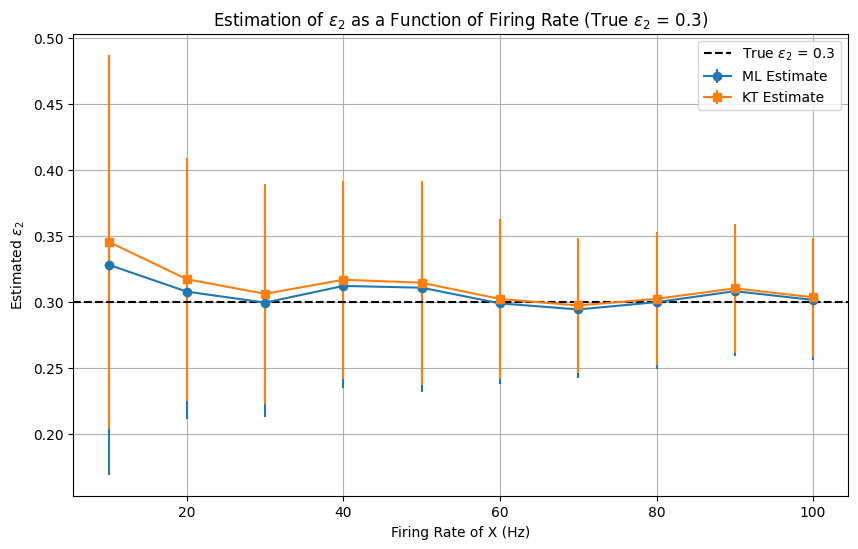

Running firing rate study for true epsilon_2 = 0.5


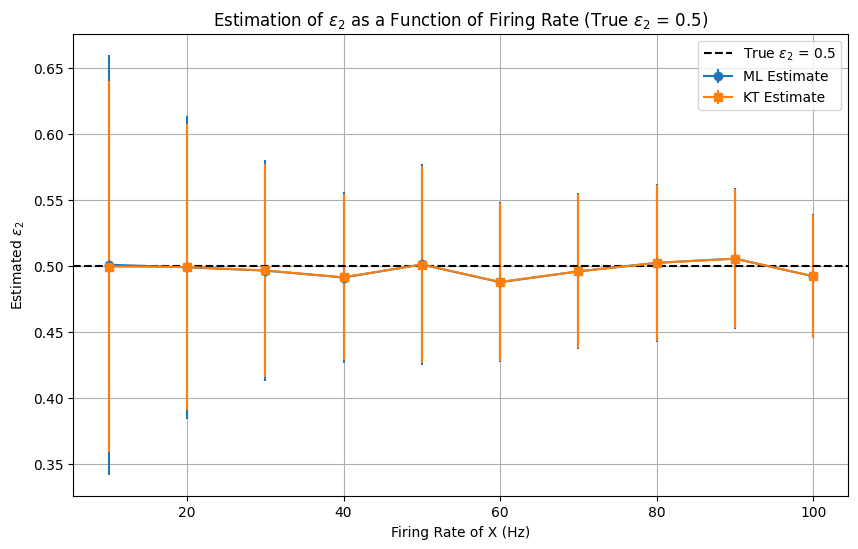

Running firing rate study for true epsilon_2 = 0.7


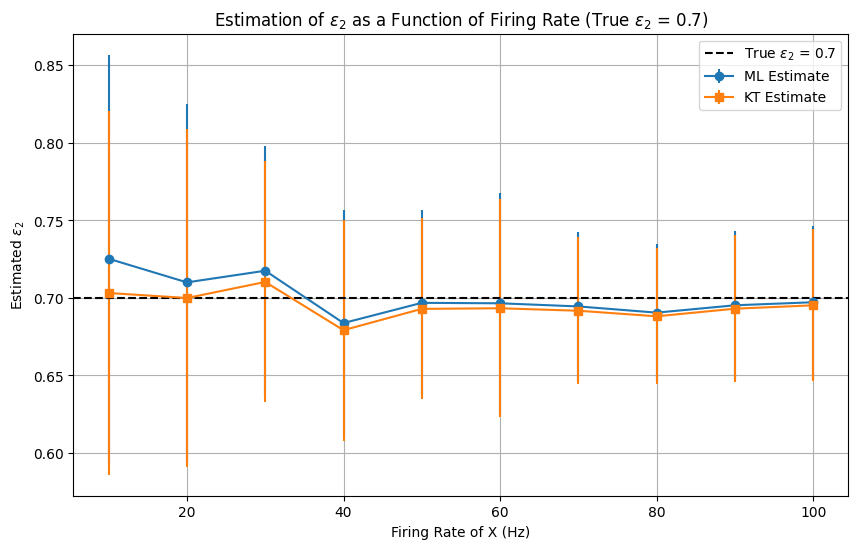

Running firing rate study for true epsilon_2 = 0.9


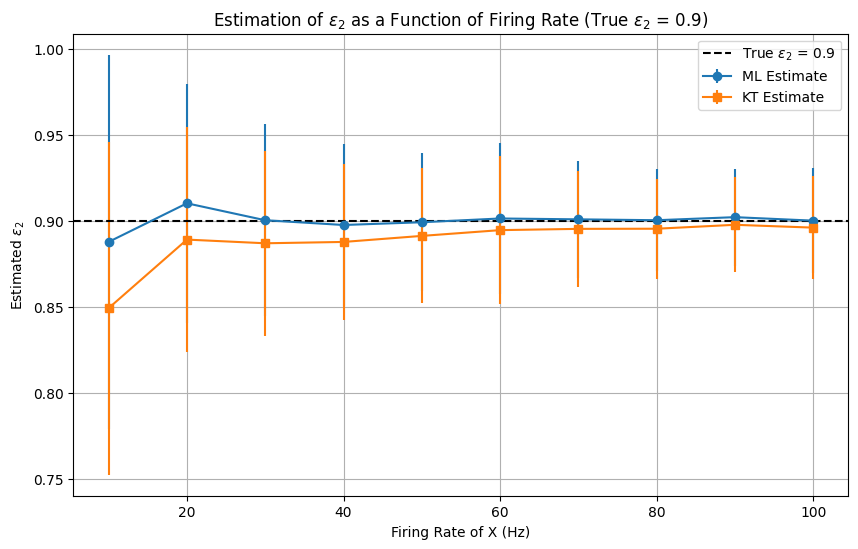

Running firing rate study for true epsilon_2 = 0.99


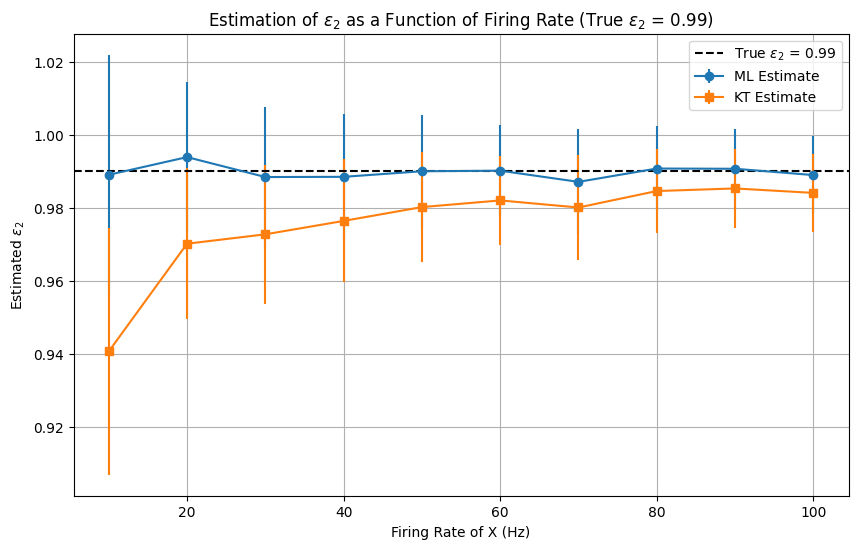

In [49]:
epsilon_2_values = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]

for epsilon_2_true in epsilon_2_values:
    print(f"Running firing rate study for true epsilon_2 = {epsilon_2_true}")
    fr_used, epsilon_2_ML_means, epsilon_2_ML_stds, epsilon_2_KT_means, epsilon_2_KT_stds = firing_rate_study(
        epsilon_2_true, fr_values, length=length, trials=trials)
    
    plt.figure(figsize=(10, 6))
    
    # Plot ML estimates with error bars
    plt.errorbar(fr_used, epsilon_2_ML_means, yerr=epsilon_2_ML_stds, fmt='o-', label='ML Estimate')
    
    # Plot KT estimates with error bars
    plt.errorbar(fr_used, epsilon_2_KT_means, yerr=epsilon_2_KT_stds, fmt='s-', label='KT Estimate')
    
    # Plot true epsilon_2 line
    plt.axhline(y=epsilon_2_true, color='k', linestyle='--', label=f'True $\\epsilon_2$ = {epsilon_2_true}')
    
    plt.xlabel('Firing Rate of X (Hz)')
    plt.ylabel('Estimated $\\epsilon_2$')
    plt.title(f'Estimation of $\\epsilon_2$ as a Function of Firing Rate (True $\\epsilon_2$ = {epsilon_2_true})')
    plt.legend()
    plt.grid(True)
    plt.show()


In [52]:
def epsilon_2_study_with_fixed_firing_rate(fr_X, epsilon_2_values, length=50, trials=100):
    """
    Study for varying epsilon_2 with a fixed firing rate.
    
    Parameters:
    - fr_X: Firing rate of X (fixed in this study).
    - epsilon_2_values: A list or array of true epsilon_2 values to test.
    - length: Length of the spike trains.
    - trials: Number of trials to run for each epsilon_2 value.
    
    Returns:
    - epsilon_2_ML_means: Mean ML estimates for each epsilon_2 value.
    - epsilon_2_ML_stds: Standard deviation of ML estimates for each epsilon_2 value.
    - epsilon_2_KT_means: Mean KT estimates for each epsilon_2 value.
    - epsilon_2_KT_stds: Standard deviation of KT estimates for each epsilon_2 value.
    """
    epsilon_2_ML_means = []
    epsilon_2_ML_stds = []
    epsilon_2_KT_means = []
    epsilon_2_KT_stds = []

    for epsilon_2_true in epsilon_2_values:
        epsilon_2_estimates_ML_trials = []
        epsilon_2_estimates_KT_trials = []
        
        for _ in range(trials):
            # Generate spike trains with fixed fr_X and varying epsilon_2_true
            X, Y = generate_spike_trains_coupl(length=length, trials=1, fr_X=fr_X, epsilon_2=epsilon_2_true)
            X = X.flatten()
            Y = Y.flatten()
            
            # Estimate epsilon_2 using ML
            epsilon_2_ML = estimate_epsilon_2_ML(X, Y)
            # Estimate epsilon_2 using KT
            epsilon_2_KT = estimate_epsilon_2_KT(X, Y)
            
            # Append estimates if they are not NaN
            if not np.isnan(epsilon_2_ML):
                epsilon_2_estimates_ML_trials.append(epsilon_2_ML)
            if not np.isnan(epsilon_2_KT):
                epsilon_2_estimates_KT_trials.append(epsilon_2_KT)
        
        # Compute mean and std estimates over trials
        mean_epsilon_2_ML = np.mean(epsilon_2_estimates_ML_trials)
        std_epsilon_2_ML = np.std(epsilon_2_estimates_ML_trials)
        
        mean_epsilon_2_KT = np.mean(epsilon_2_estimates_KT_trials)
        std_epsilon_2_KT = np.std(epsilon_2_estimates_KT_trials)
        
        epsilon_2_ML_means.append(mean_epsilon_2_ML)
        epsilon_2_ML_stds.append(std_epsilon_2_ML)
        
        epsilon_2_KT_means.append(mean_epsilon_2_KT)
        epsilon_2_KT_stds.append(std_epsilon_2_KT)
    
    return (epsilon_2_ML_means, epsilon_2_ML_stds, epsilon_2_KT_means, epsilon_2_KT_stds)

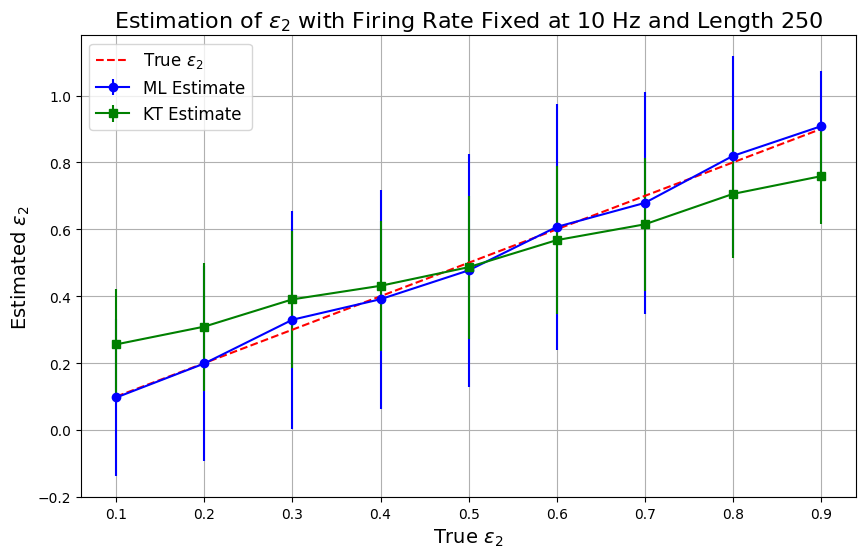

In [62]:
# Parameters for the study
fr_X = 10  # Fixed firing rate
epsilon_2_values = np.linspace(0.1, 0.9, 9)  # Range of true epsilon_2 values
length = 250  # Spike train length
trials = 100  # Number of trials for each epsilon_2

# Running the study for varying epsilon_2 and fixed firing rate
epsilon_2_ML_means, epsilon_2_ML_stds, epsilon_2_KT_means, epsilon_2_KT_stds = epsilon_2_study_with_fixed_firing_rate(
    fr_X, epsilon_2_values, length=length, trials=trials)

# Plotting the results with epsilon_2 on the x-axis
plt.figure(figsize=(10, 6))

# Plot ML estimates with error bars
plt.errorbar(epsilon_2_values, epsilon_2_ML_means, yerr=epsilon_2_ML_stds, fmt='o-', label='ML Estimate', color='blue')

# Plot KT estimates with error bars
plt.errorbar(epsilon_2_values, epsilon_2_KT_means, yerr=epsilon_2_KT_stds, fmt='s-', label='KT Estimate', color='green')

# Plot true epsilon_2 line for each value
plt.plot(epsilon_2_values, epsilon_2_values, color='red', linestyle='--', label=f'True $\\epsilon_2$')

# Add labels, legend, and grid
plt.xlabel('True $\\epsilon_2$', fontsize=14)
plt.ylabel('Estimated $\\epsilon_2$', fontsize=14)
plt.title(f'Estimation of $\\epsilon_2$ with Firing Rate Fixed at {fr_X} Hz and Length {length}', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()